In [ ]:
cd C:\Users\Avell\Aula1

##Introdução a CONVNETS (Redes Neurias Convolucionais)

Estamos prestes a mergulhar na teoria do que são os convnets e por que eles têm tanto sucesso em tarefas de visão computacional. Mas, primeiro, vamos dar uma olhada prática em um exemplo simples de convnet. Vamos treinar uma Convnet do zero para um pequeno conjunto de dados.
Ter que treinar um modelo de classificação de imagem usando muito poucos dados é uma situação comum, que você provavelmente encontrará na prática se fizer visão computacional em um contexto profissional. Algumas “poucas” amostras podem significar de algumas centenas a algumas dezenas de milhares de imagens. Como um exemplo prático, vamos nos concentrar na classificação de imagens como cães ou gatos, em um conjunto de dados contendo 3.000 fotos de gatos e cães (1.500 gatos, 1.500 cães). Nós usaremos 2.000 imagens para treinar e 1000 para validar.

As linhas de código a seguir mostram a aparência de um convnet básico. É uma pilha de camadas Conv2D e MaxPooling2D. Você verá em um minuto exatamente o que eles fazem.

## Seção 1
Nesta seção, revisaremos uma estratégia básica para resolver esse problema: treinar um novo modelo do zero usando os poucos dados que você tem. Você vai começar treinando ingenuamente um pequeno convnet nas 2.000 amostras de treinamento, sem qualquer regularização, para definir uma linha de base para o que pode ser alcançado.
Isso o levará a uma precisão de classificação de 71%. Nesse ponto, o principal problema será o ***overfitting***. Em seguida, apresentaremos a ***data augmentation***, uma técnica poderosa para mitigar o sobreajuste na visão computacional. Ao usar o aumento de dados, você melhorará a rede para alcançar uma precisão de 82%.

Na próxima seção, revisaremos mais duas técnicas essenciais para a aplicação de aprendizado profundo em pequenos conjuntos de dados: extração de recursos com uma rede pré-treinada (que o levará a uma precisão de 90% a 96%) e ajuste fino de uma rede pré-treinada ( isso o levará a uma precisão final de 97%). Juntas, essas três estratégias - treinar um pequeno modelo do zero, fazer extração de recursos usando um modelo pré-treinado e fazer o ajuste fino de um modelo pré-treinado - constituirão sua caixa de ferramentas futura para lidar com o problema de desempenho na classificação de imagens com pequenos conjuntos de dados.


In [1]:
#Importando as bibliotecas e criando nossa CONVNET
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras import models


model = models.Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))



Vejamos como as dimensões dos mapas de características mudam com cada camada sucessiva:

In [2]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

## Compilando o Modelo para Treinamento

Para a etapa de compilação, isaremos como otimizador RMSprop. 
Devido ser um problema de classificação binária, temos que colocar apenas 1 neurônio na camada de saída, sendo assim, a função de ativação a ser utilizada será a sigmóide e a Loos function, será a binary-crossentropy. Segue a tabela abaixo para utilizá-la como referência.


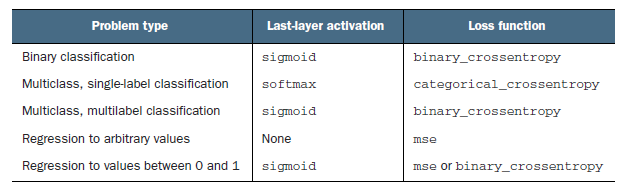

In [3]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

## Processando os Dados

Como já sabemos, os dados devem ser formatados em tensores de ponto flutuante pré-processados apropriadamente antes de serem alimentados na rede. Atualmente, os dados ficam em uma unidade como arquivos JPEG, então as etapas para colocá-los na rede são aproximadamente as seguintes:
1 Leia os arquivos de imagem.
2 Decodifique o conteúdo JPEG para grades RGB de pixels.
3 Converta-os em tensores de ponto flutuante.
4 Redimensione os valores de pixel (entre 0 e 255) para o intervalo [0, 1] (como já sabemos, as redes neurais preferem lidar com pequenos valores de entrada).

O **Keras** tem utilitários para cuidar dessas etapas automaticamente. **Keras** tem um módulo com ferramentas auxiliares de processamento de imagem, localizado em ***keras.preprocessing.image***. Em particular, ele contém a classe ***ImageDataGenerator***, que permite configurar geradores Python que podem transformar automaticamente arquivos de imagem no disco em lotes de tensores pré-processados. Isso é o que vamos usar.

In [5]:
from keras.preprocessing.image import ImageDataGenerator

#Convertendo o tamanho das imagens
train_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
      'dataset/train/',
      target_size = (150, 150),
      batch_size = 20,
      class_mode = 'binary')

validation_generator = validation_datagen.flow_from_directory(
      'dataset/validation/',
      target_size = (150, 150),
      batch_size = 20,
      class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.


## Treinando o Modelo

Vamos ajustar o modelo aos dados usando o **generator**. Fazemos isso usando o método ***fit_generator***, o equivalente a ***fit*** para geradores de dados como este. Ele espera como primeiro argumento um gerador Python que produzirá lotes de entradas e alvos indefinidamente, como este faz.
Como os dados são gerados incessantemente, o modelo **Keras** precisa saber quantas amostras retirar do gerador antes de declarar o término de uma época. Este é o papel do argumento ***steps_per_epoch***: depois de extrair lotes de ***steps_per_epoch*** do gerador - isto é, após ter executado para etapas de descida de gradiente de ***steps_per_epoch*** - o processo de ajuste irá para a próxima época. Neste caso, os lotes (***batch_size***) são 20 amostras, então serão necessários 100 lotes até que você veja
sua meta de 2.000 amostras.
Ao usar ***fit_generator***, você pode passar um argumento ***validation_data***, tanto quanto com o método ***fit***. É importante observar que este argumento pode ser um gerador de dados, mas também pode ser uma tupla de matrizes Numpy. Se você passar um gerador como ***validation_data***, espera-se que esse gerador produza lotes de dados de validação indefinidamente; portanto, você também deve especificar o argumento ***validation_steps***, que informa ao processo quantos lotes retirar do gerador de validação para avaliação.


In [12]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch = 100,
      epochs = 30,
      validation_data = validation_generator,
      validation_steps = 50)

Epoch 1/30


C:\Users\Avell\AppData\Local\Temp\ipykernel_5684\1719615851.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 [==============================] - 15s 105ms/step - loss: 0.7065 - acc: 0.4955 - val_loss: 0.6927 - val_acc: 0.5820
Epoch 2/30
100/100 [==============================] - 10s 97ms/step - loss: 0.6923 - acc: 0.5270 - val_loss: 0.6850 - val_acc: 0.5490
Epoch 3/30
100/100 [==============================] - 7s 72ms/step - loss: 0.6865 - acc: 0.5610 - val_loss: 0.6825 - val_acc: 0.5300
Epoch 4/30
100/100 [==============================] - 8s 83ms/step - loss: 0.6723 - acc: 0.5875 - val_loss: 0.6652 - val_acc: 0.6110
Epoch 5/30
100/100 [==============================] - 10s 96ms/step - loss: 0.6228 - acc: 0.6590 - val_loss: 0.6717 - val_acc: 0.6390
Epoch 6/30
100/100 [==============================] - 10s 97ms/step - loss: 0.6050 - acc: 0.6690 - val_loss: 0.6499 - val_acc: 0.6260
Epoch 7/30
100/100 [==============================] - 10s 97ms/step - loss: 0.5501 - acc: 0.7140 - val_loss: 0.6476 - val_acc: 0.6570
Epoch 8/30
100/100 [==============================] - 10s 98ms/step - loss

##Salvando o Modelo

In [ ]:
model.save('cats_and_dogs_small_1.h5')

## Exibindo curvas de perda (Loss) e precisão (accuracy) durante o treinamento

Vamos representar graficamente a ***Loss*** e a ***accuracy*** do modelo sobre os dados de treinamento e validação durante o treinamento

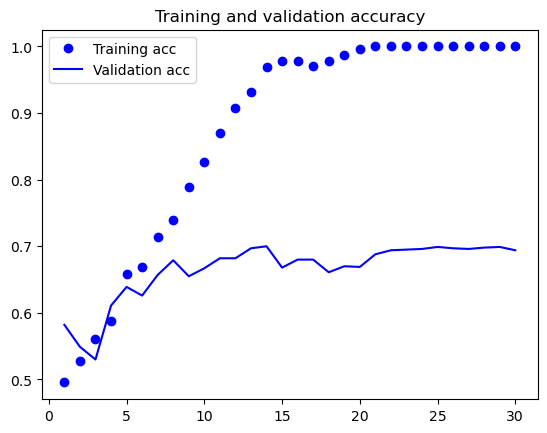

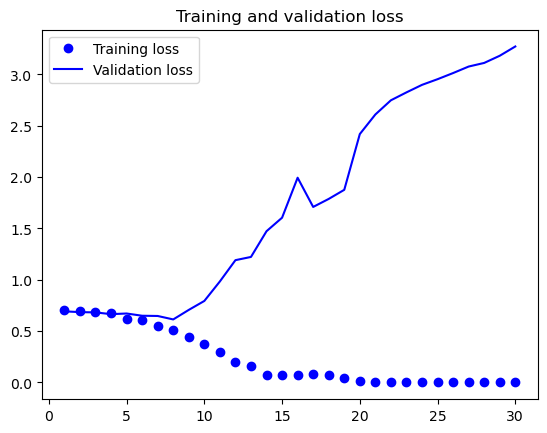

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()